# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import json
import os
import plotly.graph_objs as go
import chart_studio.plotly as py
import chart_studio.tools
from scipy.stats import chi2_contingency
from itertools import product
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from statsmodels.stats.proportion import proportions_ztest
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
chart_studio.tools.set_credentials_file(username='', api_key='')

# Datasets

In [3]:
## Note 1.
hiefData = \
    pd.read_csv(r'..\data\hiefData.csv', comment='#')
usVeteransFKBP5 = \
    pd.read_csv(r'..\data\usVeteransFKBP5.csv', comment='#')
ptsdWorldMentalHealthSurvey = \
    pd.read_csv(r'..\data\ptsdWorldMentalHealthSurvey.csv', comment='#')
healthCarePriceIndex = \
    pd.read_csv(r'..\data\healthCarePriceIndex.csv', comment='#')
## Note 2.
rs1360780Data = \
    pd.read_csv(r'..\data\rs1360780_frequency.tsv', sep='\t', 
                skiprows=12, header=0).drop(columns=['#Study'])
rs3800373Data = \
    pd.read_csv(r'..\data\rs3800373_frequency.tsv', sep='\t',
                skiprows=12, header=0).drop(columns=['#Study'])
rs9296158Data = \
    pd.read_csv(r'..\data\rs9296158_frequency.tsv', sep='\t',
                skiprows=12, header=0).drop(columns=['#Study'])
rs9470080Data = \
    pd.read_csv(r'..\data\rs9470080_frequency.tsv', sep='\t',
                skiprows=12, header=0).drop(columns=['#Study'])
## Note 3.
WorldValuesSurveyData = \
    pd.read_csv(r'..\data\WVS_Cross-National_Wave_7_inverted_csv_v6_0.csv', 
                low_memory=False).fillna(0)
healthCareQuality = pd.read_csv(r'..\data\healthCareQuality.csv', comment='#')

# Applied Analysis

## Analysis Objects

### Countryparser

In [4]:
class Countryparser:
    
    countryScope = {
        "COL": ["Colombia", "Colombia (Medellin)"],
        "IRQ": ["Iraq"],
        "PER": ["Peru"],
        "CHN": ["PRC China", "China"],
        "UKR": ["Ukraine"],
        "BRA": ["Brazil"],
        "BGR": ["Bulgaria"],
        "MEX": ["Mexico"],
        "ROU": ["Romania"],
        "ZAF": ["South Africa"],
        "AUS": ["Australia"],
        "BEL": ["Belgium"],
        "DEU": ["Germany", "German Federal Republic"],
        "ISR": ["Israel"],
        "ITA": ["Italy"],
        "JPN": ["Japan"],
        "NZL": ["New Zealand"],
        "GBR": ["United Kingdom", "Northern Ireland"],
        "PRT": ["Portugal"],
        "ESP": ["Spain", "Spain (Murcia)"],
        "NLD": ["The Netherlands", "Netherlands"],
        "USA": ["The USA", "USA", "United States of America", "United States"],
        "FRA": ["France"]
    }

    def standardizeCountryNames(data_Frame, country_Col, countryScope):
        # Creating an empty dictionary who's key is the country name, and who's value is the corresponding ISO code.
        standardizedCountries = {}
        # This loops through each key-value pair in the country_scope dictionary. iso_code is the key (the ISO country code), and names is the value (a list of country names).
        for iso_Code, names in countryScope.items():
            for name in names:
                standardizedCountries[name] = iso_Code
        # This maps the country names in the specified column of the DataFrame to their corresponding ISO codes using the standardized_countries dictionary.
        # The .fillna() method in this this case ensures that any country name not found in the countryScope remains unchanged.
        data_Frame[country_Col] = data_Frame[country_Col].map(
            standardizedCountries).fillna(data_Frame[country_Col])
        return data_Frame

### Bioparser

In [5]:
class Bioparser:

    @staticmethod
    def splitAlleleToDict(data_frame: pd.DataFrame, df_name: str) -> dict:
        def splitAllele(allele):
            try:
                letter, value = allele.split('=', 1)
                return letter, float(value)
            except ValueError:
                return allele, None  # Handle unexpected formats
        # Check if 'Ref Allele' and 'Alt Allele' columns exist
        if 'Ref Allele' not in data_frame.columns or 'Alt Allele' not in data_frame.columns:
            raise KeyError(
                "'Ref Allele' or 'Alt Allele' column not found in the DataFrame")
        # Apply the function to split 'Ref Allele' and 'Alt Allele'
        data_frame[['Ref Allele Letter', 'Ref Allele Value']
                   ] = data_frame['Ref Allele'].apply(splitAllele).tolist()
        data_frame[['Alt Allele Letter', 'Alt Allele Value']
                   ] = data_frame['Alt Allele'].apply(splitAllele).tolist()
        # Drop the original 'Ref Allele' and 'Alt Allele' columns
        data_frame = data_frame.drop(columns=['Ref Allele', 'Alt Allele'])
        # Initialize the dictionary
        populationAlleleFrequency = {}
        # Group by 'Population' and calculate the mean of 'Ref Allele Value' and 'Alt Allele Value'
        allele_grouped = data_frame.groupby(['Population']).agg({
            'Ref Allele Value': 'mean',
            'Alt Allele Value': 'mean'
        }).reset_index()
        # Populate the dictionary with the required frequencies and HWE predictions
        for _, row in allele_grouped.iterrows():
            population = row['Population']
            p = row['Ref Allele Value']
            q = row['Alt Allele Value']
            if pd.notna(p) and pd.notna(q):
                ref_ref = p ** 2
                alt_alt = q ** 2
                ref_alt = 2 * p * q
                populationAlleleFrequency[population] = {
                    'Ref/Ref': ref_ref,
                    'Alt/Alt': alt_alt,
                    'Ref/Alt': ref_alt
                }
        # Determine the dictionary name dynamically based on the provided DataFrame name
        dict_name = df_name + "PopulationAlleleFrequency"
        return {dict_name: populationAlleleFrequency}

### FKBP5Processor

In [6]:
class FKBP5Processor:
    def __init__(self, df):
        self.df = df

    def extract_frequencies(self):
        for col in ['1:1', '1:2', '2:2']:
            self.df[f'Frequency {col}'] = self.df[col].str.extract(
                r'\((\d+\.\d+)\)').astype(float)
        return self.df

    def add_snp_labels(self):
        for col in ['1:1', '1:2', '2:2']:
            self.df[f'SNP_{col}'] = self.df['SNP'] + f' {col}'
        return self.df

    def process(self):
        self.extract_frequencies()
        self.add_snp_labels()
        return self.df

### PTSD & Trauma Prevalence Plot

In [7]:
# Standardize country names for the two relevant datasets
ptsdWorldMentalHealthSurvey = Countryparser.standardizeCountryNames(ptsdWorldMentalHealthSurvey, 'Country', Countryparser.countryScope)
ptsdWorldMentalHealthSurveyCopy = ptsdWorldMentalHealthSurvey.copy()
# Categorizing trauma and PTSD columns into distinct categories

ptsdWorldMentalHealthSurveyCopy['traumaCategory'] = pd.cut(
    ptsdWorldMentalHealthSurveyCopy['Trauma exposure (%)'], 
    bins=[-1, 55, 70, float('inf')], 
    labels=['Low Trauma', 'Moderate Trauma', 'High Trauma']
).astype(str)

ptsdWorldMentalHealthSurveyCopy['PTSDCategory'] = pd.cut(
    ptsdWorldMentalHealthSurveyCopy[
        'Lifetime prevalence of PTSD in total sample (%)'],
    bins=[-1, 2.7, 5.3, float('inf')],
    labels=['Low PTSD', 'Moderate PTSD', 'High PTSD']
).astype(str)

# Create a new column that holds the value of the combined categories for each country
ptsdWorldMentalHealthSurveyCopy['Combined Category'] = \
    ptsdWorldMentalHealthSurveyCopy['traumaCategory'] + '-' + ptsdWorldMentalHealthSurveyCopy['PTSDCategory']

# Create the choropleth map
ptsdToTraumaMap = px.choropleth(
    ptsdWorldMentalHealthSurveyCopy,
    locations="Country",
    color="Combined Category",
    hover_name="Country",
    hover_data=["Lifetime prevalence of PTSD in total sample (%)", "Trauma exposure (%)"],
    color_discrete_map={
        'Low Trauma-Low PTSD': '#66c2a5',            
        'Low Trauma-Moderate PTSD': '#41ab5d',       
        'Low Trauma-High PTSD': '#238b45',           
        'Moderate Trauma-Low PTSD': '#fee08b',       
        'Moderate Trauma-Moderate PTSD': '#f37726',  
        'Moderate Trauma-High PTSD': '#5e7787',     
        'High Trauma-Low PTSD': '#156794',         
        'High Trauma-Moderate PTSD': '#ca431b',      
        'High Trauma-High PTSD': '#b20000'          
    },
    title="Lifetime PTSD Prevalence & Trauma Exposure by Country",
    category_orders={
        "Combined Category": [
            'Low Trauma-Low PTSD', 'Low Trauma-Moderate PTSD', 'Low Trauma-High PTSD',
            'Moderate Trauma-Low PTSD', 'Moderate Trauma-Moderate PTSD', 'Moderate Trauma-High PTSD',
            'High Trauma-Low PTSD', 'High Trauma-Moderate PTSD', 'High Trauma-High PTSD']
    }
)
# Update the geographic layout
ptsdToTraumaMap.update_geos(projection_type='orthographic')
# Show the map
# py.plot(ptsdToTraumaMap, filename='ptsdToTraumaMap', auto_open=True)
# ptsdToTraumaMap.show()

## PTSD Against Trauma and Healthcare Plot

C:\Users\joelm\AppData\Local\Temp\ipykernel_12852\547765907.py:40: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



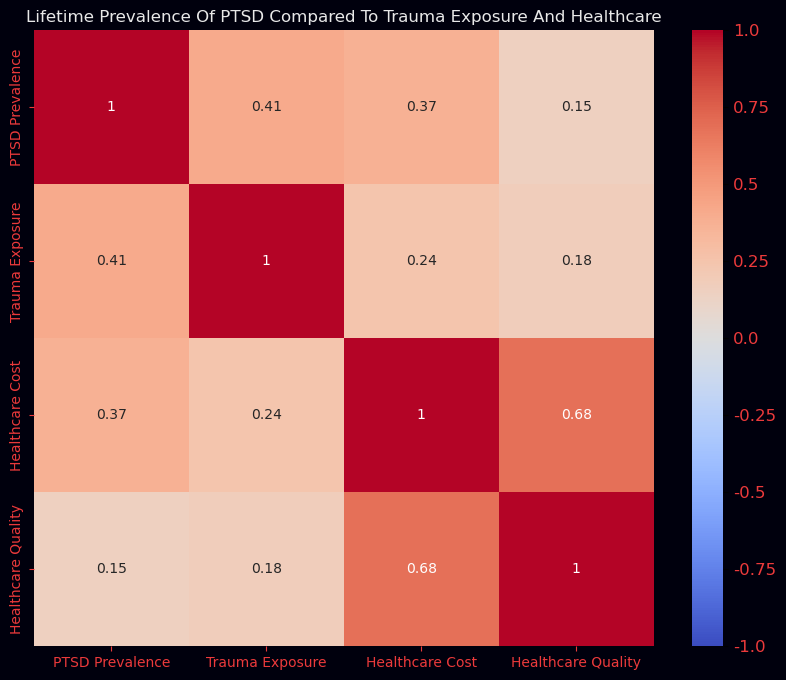

In [8]:
# Here we're standardizing the country names for the two relevant datasets we need for this particular analysis.
ptsdWorldMentalHealthSurvey = Countryparser.standardizeCountryNames(ptsdWorldMentalHealthSurvey, 'Country', Countryparser.countryScope)
healthCarePriceIndex = Countryparser.standardizeCountryNames(healthCarePriceIndex, 'Country', Countryparser.countryScope)
healthCareQuality = Countryparser.standardizeCountryNames(healthCareQuality, 'Country', Countryparser.countryScope)
# Merging healthcare price index with PTSD and trauma exposure data.
ptsdAndHealthCare = ptsdWorldMentalHealthSurvey.merge(healthCarePriceIndex[['Country', 'Healthcare price index world average = 100']], on='Country', how='inner')
ptsdAndHealthCareAndHealthQuality = ptsdAndHealthCare.merge(healthCareQuality[['Country', 'Health Care Index']], on='Country', how='inner')
# Verify that the merged DataFrame is not empty.
if not ptsdAndHealthCareAndHealthQuality.empty:
    # Creating DataFrame set to the prevalence of PTSD, trauma exposure, and healthcare price index
    ptsdAgainstTraumaAndHealthCareAndHealthQuality = ptsdAndHealthCareAndHealthQuality[[
        'Lifetime prevalence of PTSD in total sample (%)', 'Trauma exposure (%)', 'Healthcare price index world average = 100', 'Health Care Index']]
    ptsdAgainstTraumaAndHealthCareAndHealthQualityCopy = ptsdAgainstTraumaAndHealthCareAndHealthQuality.copy()
    # Renaming columns for correlation matrix due to large size of column names.
    ptsdAgainstTraumaAndHealthCareAndHealthQualityCopy.rename(
        columns={
            'Lifetime prevalence of PTSD in total sample (%)': 'PTSD Prevalence',
            'Trauma exposure (%)': 'Trauma Exposure',
            'Healthcare price index world average = 100': 'Healthcare Cost', 
            'Health Care Index': 'Healthcare Quality'},
        inplace=True
    )
    # Creating correlation DataFrame.
    ptsdAgainstTraumaAndHealthCareCorrMatrix = ptsdAgainstTraumaAndHealthCareAndHealthQualityCopy.corr()
    # Creating subplot for heatmap.
    fig = plt.figure(figsize=(10, 8))
    fig.patch.set_color('#00000d')
    ax = plt.subplot(111)
    # Generating heatmap of correlation matrix, and normalizing variable scale to be on point 0 +/- 1.
    sns.heatmap(ptsdAgainstTraumaAndHealthCareCorrMatrix,
                annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=ax)
    plt.title("Lifetime Prevalence Of PTSD Compared To Trauma Exposure And Healthcare", color='#e8e8e8')
    # plt.xlabel('', color='#ec3a3b')
    ax.tick_params(axis='x', colors='#ec3a3b')
    ax.tick_params(axis='y', colors='#ec3a3b')
    plt.xticks(rotation=0)
    plt.yticks(rotation=90)
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=12)  # Adjust label size
    cbar.ax.set_yticklabels(cbar.ax.get_yticks(
    ), color='#ec3a3b')
    # Displaying generated heatmap.
    plt.show()

### SNP & PTSD Prevalence Plot

In [9]:
processor = FKBP5Processor(usVeteransFKBP5)
processed_df = processor.process()
# Reshaping the data
reshapedData11 = processed_df[['SNP_1:1', 'Frequency 1:1', 'Group']].rename(columns={'SNP_1:1': 'SNP_Genotype', 'Frequency 1:1': 'Frequency'})
reshapedData12 = processed_df[['SNP_1:2', 'Frequency 1:2', 'Group']].rename(columns={'SNP_1:2': 'SNP_Genotype', 'Frequency 1:2': 'Frequency'})
reshapedData22 = processed_df[['SNP_2:2', 'Frequency 2:2', 'Group']].rename(columns={'SNP_2:2': 'SNP_Genotype', 'Frequency 2:2': 'Frequency'})
reshapedSNPData = pd.concat([reshapedData11, reshapedData12, reshapedData22])
# Creating the scatter plot
fig = px.scatter(reshapedSNPData, x='SNP_Genotype', y='Frequency', color='Group',
                 title='Genotype Frequencies in Control and PTSD Groups',
                 labels={'SNP_Genotype': 'SNP and Genotype',
                         'Frequency': 'Frequency'},
                 symbol='Group', size_max=10)
# Updating the layout
fig.update_layout(
    title_font_size=24,
    xaxis_title_font_size=18,
    yaxis_title_font_size=18,
    legend_title_font_size=16,
    legend_font_size=14,
    xaxis_tickangle=-90,
    xaxis_tickfont_size=12,
    yaxis_tickfont_size=14,
    width=1200,
    height=800,
    margin=dict(l=40, r=40, t=80, b=40)
)
fig.show()

### SNP Allele Combination Frequencies By Population Predicted Via The Hardy–Weinberg Principle

In [10]:
# Example usage with a DataFrame
rs1360780DataResult = Bioparser.splitAlleleToDict(rs1360780Data, 'rs1360780Data')
rs3800373DataResult = Bioparser.splitAlleleToDict(rs3800373Data, 'rs1360780Data')
rs9296158DataResult = Bioparser.splitAlleleToDict(rs9296158Data, 'rs1360780Data')
rs9470080DataResult = Bioparser.splitAlleleToDict(rs9470080Data, 'rs1360780Data')
# Print the result in a nicely formatted way
# print(json.dumps(rs1360780DataResult, indent=4))
# print(json.dumps(rs3800373DataResult, indent=4))
# print(json.dumps(rs9296158DataResult, indent=4))
# print(json.dumps(rs9470080DataResult, indent=4))
print(rs1360780DataResult)
print(rs3800373DataResult)
print(rs9296158DataResult)
print(rs9470080DataResult)

{'rs1360780DataPopulationAlleleFrequency': {'ACPOP': {'Ref/Ref': 0.08008899999999998, 'Alt/Alt': 0.5140889999999999, 'Ref/Alt': 0.40582199999999996}, 'Africa': {'Ref/Ref': 0.188356, 'Alt/Alt': 0.3203559999999999, 'Ref/Alt': 0.49128799999999995}, 'African': {'Ref/Ref': 0.17135791411600004, 'Alt/Alt': 0.3424385583062499, 'Ref/Alt': 0.48447727321}, 'AfricanAmerican': {'Ref/Ref': 0.1701892516, 'Alt/Alt': 0.3451092516, 'Ref/Alt': 0.4847014968}, 'America': {'Ref/Ref': 0.04161599999999999, 'Alt/Alt': 0.6336160000000001, 'Ref/Alt': 0.324768}, 'American': {'Ref/Ref': 0.09070788650624999, 'Alt/Alt': 0.48835288650624986, 'Ref/Alt': 0.4209392269874999}, 'Ashkenazi Jewish': {'Ref/Ref': 0.07431076, 'Alt/Alt': 0.52911076, 'Ref/Alt': 0.39657848}, 'Asian': {'Ref/Ref': 0.06263340444444443, 'Alt/Alt': 0.5892097600000001, 'Ref/Alt': 0.38420938666666665}, 'CRM': {'Ref/Ref': 0.068121, 'Alt/Alt': 0.546121, 'Ref/Alt': 0.385758}, 'CentralAmerican': {'Ref/Ref': 0.13608721000000001, 'Alt/Alt': 0.39828721, 'Ref/A

### Individual SNP Combinations To PTSD P-Values

In [11]:
# Extract counts from the original data
usVeteransFKBP5['Count 1:1'] = usVeteransFKBP5['1:1'].str.extract(r'(\d+)').astype(float)
usVeteransFKBP5['Count 1:2'] = usVeteransFKBP5['1:2'].str.extract(r'(\d+)').astype(float)
usVeteransFKBP5['Count 2:2'] = usVeteransFKBP5['2:2'].str.extract(r'(\d+)').astype(float)

# Define SNPs and genotypes
snps = ['rs1360780', 'rs3800373', 'rs9296158', 'rs9470080']
genotypes = ['1:1', '1:2', '2:2']

# Create a dictionary to hold genotype counts for each SNP
genotype_counts = {}
for snp in snps:
    genotype_counts[snp] = {}
    for genotype in genotypes:
        column_name = f'{snp} {genotype}'
        count_column = f'Count {genotype}'
        usVeteransFKBP5[column_name] = usVeteransFKBP5.apply(
            lambda row: row[count_column] if row['SNP'].startswith(snp) else 0, axis=1)
        genotype_counts[snp][genotype] = usVeteransFKBP5.groupby('Group')[
            column_name].sum()

# Generate all possible genotype combinations
combinations = list(product(genotypes, repeat=len(snps)))

# Calculate P-value for each combination
combination_p_values = []

for combination in combinations:
    table = []
    for group in ['Control', 'PTSD']:
        row = []
        for snp, genotype in zip(snps, combination):
            row.append(genotype_counts[snp][genotype][group])
        table.append(row)

    # Ensure we have a valid table
    if len(table) == 2 and all(len(row) == len(snps) for row in table):
        _, p, _, _ = chi2_contingency(table)
        combination_str = ', '.join(
            [f'{snp} {genotype}' for snp, genotype in zip(snps, combination)])
        combination_p_values.append((combination_str, p))

# Convert the list of tuples to a DataFrame for better readability
combination_p_values_df = pd.DataFrame(
    combination_p_values, columns=['Combination', 'P_value'])

# Set display options to show all rows and expand columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

# Display the results
print("P-values for specific SNP genotype combinations to PTSD:")
print(combination_p_values_df)

P-values for specific SNP genotype combinations to PTSD:
                                                   Combination       P_value
0   rs1360780 1:1, rs3800373 1:1, rs9296158 1:1, rs9470080 1:1  3.385781e-07
1   rs1360780 1:1, rs3800373 1:1, rs9296158 1:1, rs9470080 1:2  1.219333e-05
2   rs1360780 1:1, rs3800373 1:1, rs9296158 1:1, rs9470080 2:2  1.462120e-06
3   rs1360780 1:1, rs3800373 1:1, rs9296158 1:2, rs9470080 1:1  8.889484e-05
4   rs1360780 1:1, rs3800373 1:1, rs9296158 1:2, rs9470080 1:2  2.187117e-04
5   rs1360780 1:1, rs3800373 1:1, rs9296158 1:2, rs9470080 2:2  3.843560e-06
6   rs1360780 1:1, rs3800373 1:1, rs9296158 2:2, rs9470080 1:1  7.822273e-01
7   rs1360780 1:1, rs3800373 1:1, rs9296158 2:2, rs9470080 1:2  5.802410e-05
8   rs1360780 1:1, rs3800373 1:1, rs9296158 2:2, rs9470080 2:2  9.805414e-08
9   rs1360780 1:1, rs3800373 1:2, rs9296158 1:1, rs9470080 1:1  1.293572e-05
10  rs1360780 1:1, rs3800373 1:2, rs9296158 1:1, rs9470080 1:2  9.835014e-04
11  rs1360780 1:1, 

#### Individual SNP Combinations To PTSD With P-Values Under 0.001%

In [12]:
# Ensure the P_value column is in float format before applying any formatting
combination_p_values_df['P_value'] = combination_p_values_df['P_value'].astype(float)
# Convert p-values from scientific notation to decimal format
combination_p_values_df['P_value'] = combination_p_values_df['P_value'].apply(lambda x: '{:.10f}'.format(x))
# Filter for combinations with P-value < 0.001
significant_combinations_0_001 = combination_p_values_df[combination_p_values_df['P_value'].astype(float) < 0.001]
# Sort the significant combinations from most to least significant
significant_combinations_0_001 = significant_combinations_0_001.sort_values(by='P_value', ascending=True)
# Display the significant combinations with threshold 0.001
print("Significant SNP genotype combinations associated with PTSD (P-value < 0.001):")
print(significant_combinations_0_001)

Significant SNP genotype combinations associated with PTSD (P-value < 0.001):
                                                   Combination       P_value
8   rs1360780 1:1, rs3800373 1:1, rs9296158 2:2, rs9470080 2:2  0.0000000981
0   rs1360780 1:1, rs3800373 1:1, rs9296158 1:1, rs9470080 1:1  0.0000003386
24  rs1360780 1:1, rs3800373 2:2, rs9296158 2:2, rs9470080 1:1  0.0000006723
2   rs1360780 1:1, rs3800373 1:1, rs9296158 1:1, rs9470080 2:2  0.0000014621
26  rs1360780 1:1, rs3800373 2:2, rs9296158 2:2, rs9470080 2:2  0.0000026004
18  rs1360780 1:1, rs3800373 2:2, rs9296158 1:1, rs9470080 1:1  0.0000037459
5   rs1360780 1:1, rs3800373 1:1, rs9296158 1:2, rs9470080 2:2  0.0000038436
17  rs1360780 1:1, rs3800373 1:2, rs9296158 2:2, rs9470080 2:2  0.0000061504
1   rs1360780 1:1, rs3800373 1:1, rs9296158 1:1, rs9470080 1:2  0.0000121933
9   rs1360780 1:1, rs3800373 1:2, rs9296158 1:1, rs9470080 1:1  0.0000129357
21  rs1360780 1:1, rs3800373 2:2, rs9296158 1:2, rs9470080 1:1  0.000016353

### P-Value For Trauma To PTSD

In [14]:
# Ensure the traumaCategory and PTSDCategory columns exist in ptsdWorldMentalHealthSurveyCopy
ptsdWorldMentalHealthSurveyCopy['traumaCategory'] = pd.cut(ptsdWorldMentalHealthSurveyCopy['Trauma exposure (%)'], bins=[-1, 55, 70, float('inf')], labels=['Low Trauma', 'Moderate Trauma', 'High Trauma']).astype(str)
ptsdWorldMentalHealthSurveyCopy['PTSDCategory'] = pd.cut(ptsdWorldMentalHealthSurveyCopy['Lifetime prevalence of PTSD in total sample (%)'], bins=[-1, 2.7, 5.3, float('inf')], labels=['Low PTSD', 'Moderate PTSD', 'High PTSD']).astype(str)
# Create a contingency table for trauma exposure and PTSD categories
trauma_ptsd_table = pd.crosstab(ptsdWorldMentalHealthSurveyCopy['traumaCategory'], ptsdWorldMentalHealthSurveyCopy['PTSDCategory'])
# Perform chi-square test
chi2_trauma_ptsd, p_trauma_ptsd, _, _ = chi2_contingency(trauma_ptsd_table)
print(f"P-value for Trauma to PTSD: {p_trauma_ptsd}")

P-value for Trauma to PTSD: 0.07388457141281733


### P-Value Of PTSD And Combat Experience

In [15]:
n_obs = 1000
# Number of soldiers with PTSD and combat experience
count = int(0.39 * n_obs)
# Hypothesized proportion of soldiers with combat experience in the general soldier population
# This can be adjusted based on actual data or different assumptions
hypothetical_proportion = 0.29
# Perform Z-test for single proportions
stat, p_value = proportions_ztest(count, n_obs, hypothetical_proportion)
p_value

8.967865950885864e-11

# Applied Logistic Regression Model

In [16]:
np.random.seed(42)

# Generating more complex synthetic data
nSamples = 100
# Creating random frequencies for genotypes, introducing some noise
syntheticGenotypeFrequencies = np.random.randint(100, 2000, size=(
    nSamples, 4*3)) + np.random.normal(0, 100, (nSamples, 4*3))

# Normalizing genotype frequencies to make them resemble probabilities
scaler = MinMaxScaler()
syntheticGenotypeProbabilities = scaler.fit_transform(
    syntheticGenotypeFrequencies)

# Use a more complex model to generate the target variable, mixing influences from multiple SNPs
influenceWeights = np.random.rand(12)  # Random weights for each genotype
syntheticTarget = (np.dot(syntheticGenotypeProbabilities, influenceWeights) > np.median(
    np.dot(syntheticGenotypeProbabilities, influenceWeights))).astype(int)

# Feature names for each SNP and genotype
featureNames = []
snps = ['rs1360780', 'rs3800373', 'rs9296158', 'rs9470080']
genotypes = ['1:1', '1:2', '2:2']
for snp in snps:
    for genotype in genotypes:
        featureNames.append(f"{snp} {genotype}")

# Create a DataFrame for the synthetic dataset
syntheticData= pd.DataFrame(
    syntheticGenotypeProbabilities, columns=featureNames)
syntheticData['PTSD_Likelihood'] = syntheticTarget

# Splitting the synthetic data
X_synthetic = syntheticData.drop('PTSD_Likelihood', axis=1)
y_synthetic = syntheticData['PTSD_Likelihood']
X_train_syn, X_test_syn, y_train_syn, y_test_syn = train_test_split(
    X_synthetic, y_synthetic, test_size=0.3, random_state=42)

# Training a Random Forest model
model_rf_synthetic = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf_synthetic.fit(X_train_syn, y_train_syn)

# Evaluating el model
train_accuracy_rf_syn = model_rf_synthetic.score(X_train_syn, y_train_syn)
test_accuracy_rf_syn = model_rf_synthetic.score(X_test_syn, y_test_syn)

print("Training Accuracy:", train_accuracy_rf_syn)
print("Testing Accuracy:", test_accuracy_rf_syn)

# Function to predict PTSD probability given specific gene alleles


def predict_ptsd_probability(rs1360780, rs3800373, rs9296158, rs9470080):
    patientData = {
        'rs1360780 1:1': 1 if rs1360780 == '1:1' else 0,
        'rs1360780 1:2': 1 if rs1360780 == '1:2' else 0,
        'rs1360780 2:2': 1 if rs1360780 == '2:2' else 0,
        'rs3800373 1:1': 1 if rs3800373 == '1:1' else 0,
        'rs3800373 1:2': 1 if rs3800373 == '1:2' else 0,
        'rs3800373 2:2': 1 if rs3800373 == '2:2' else 0,
        'rs9296158 1:1': 1 if rs9296158 == '1:1' else 0,
        'rs9296158 1:2': 1 if rs9296158 == '1:2' else 0,
        'rs9296158 2:2': 1 if rs9296158 == '2:2' else 0,
        'rs9470080 1:1': 1 if rs9470080 == '1:1' else 0,
        'rs9470080 1:2': 1 if rs9470080 == '1:2' else 0,
        'rs9470080 2:2': 1 if rs9470080 == '2:2' else 0
    }
    # Convert patientData into DataFrame to be used with the trained model
    # [patientData] wraps the dictionary to form a single row DataFrame
    new_patient_df = pd.DataFrame([patientData])
    probabilities = model_rf_synthetic.predict_proba(new_patient_df)
    return probabilities[0][1]  # Probability of PTSD


# Generate all possible combinations of alleles for the 4 SNPs
allele_combinations = list(product(genotypes, repeat=4))

# Calculate the PTSD probability for each combination
probabilities = []
for combination in allele_combinations:
    rs1360780, rs3800373, rs9296158, rs9470080 = combination
    prob = predict_ptsd_probability(rs1360780, rs3800373, rs9296158, rs9470080)
    probabilities.append((combination, prob))

# Sort combinations by predicted PTSD probability in descending order
sorted_probabilities = sorted(probabilities, key=lambda x: x[1], reverse=True)

# Display the sorted combinations with their probabilities
print("\nAllele combinations sorted by PTSD probability (from highest to lowest):")
for combination, prob in sorted_probabilities:
    print(f"{combination}: {prob:.2f}")

# Example usage of the function
rs1360780 = '1:2'
rs3800373 = '1:1'
rs9296158 = '2:2'
rs9470080 = '1:1'
probability_of_ptsd = predict_ptsd_probability(rs1360780, rs3800373, rs9296158, rs9470080)
print(f"\nPredicted probability of PTSD for the given gene alleles ({rs1360780}, {rs3800373}, {rs9296158}, {rs9470080}): {probability_of_ptsd:.2f}")

Training Accuracy: 1.0
Testing Accuracy: 0.8

Allele combinations sorted by PTSD probability (from highest to lowest):
('1:2', '1:1', '1:1', '1:2'): 0.64
('1:2', '1:1', '1:1', '2:2'): 0.64
('1:2', '1:1', '1:1', '1:1'): 0.58
('1:2', '1:2', '1:1', '2:2'): 0.58
('1:2', '2:2', '1:1', '2:2'): 0.53
('1:2', '1:2', '1:1', '1:2'): 0.50
('2:2', '1:2', '1:1', '2:2'): 0.49
('1:2', '1:2', '1:1', '1:1'): 0.47
('1:2', '2:2', '1:1', '1:2'): 0.46
('2:2', '1:1', '1:1', '2:2'): 0.45
('1:2', '2:2', '1:1', '1:1'): 0.44
('2:2', '2:2', '1:1', '2:2'): 0.44
('1:1', '1:2', '1:1', '2:2'): 0.43
('1:1', '1:1', '1:1', '2:2'): 0.41
('1:1', '2:2', '1:1', '2:2'): 0.40
('1:2', '1:1', '1:2', '1:2'): 0.40
('1:2', '1:1', '1:2', '2:2'): 0.40
('2:2', '1:2', '1:1', '1:1'): 0.39
('2:2', '2:2', '2:2', '2:2'): 0.39
('2:2', '1:1', '1:1', '1:1'): 0.37
('1:2', '1:1', '2:2', '2:2'): 0.36
('2:2', '2:2', '1:1', '1:1'): 0.36
('1:1', '1:2', '1:1', '1:1'): 0.35
('1:2', '1:1', '1:2', '1:1'): 0.35
('1:2', '1:1', '2:2', '1:2'): 0.35
('2:2'

# Reference Notes
1. Declaring comments within each CSV via the `comment=` command.
2. TSV files can be read via the CSV reader, however they must delineate that the columns are separated by tabs rather than commas via the `sep='\t'` command. Likewise we are skipping the first 12 rows of the referenced file due to the odd file structure and are setting the header to the index of line we just skipped, which in our case would be 0.
3. CSV parameter low memory was set to false in order to resolve mixed type issue occurring due to file being processed in chunks rather than a whole.